In [4]:
import pandas as pd
import numpy as np

from keras.models import Model, load_model
from keras.layers import Input, LSTM, Dense, Reshape
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.layers import Embedding


import tensorflow as tf
import tensorflow.keras.backend as K

import matplotlib.pyplot as plt
import nltk
from collections import Counter
import tqdm.notebook as tqdm
import numpy as np

import random


##Preprocessing and loading data

In [8]:
# Total number of samples to read
N = 30823
hi_counter = Counter()
hi_sentences=[]
en_counter = Counter()
en_sentences=[]
with open("Hindi - Word Transliteration Pairs 1 (1).txt", encoding='utf-8') as f:
    for line in tqdm.tqdm(f, total=N, desc="Reading file:"):
        en, hi = line.strip().split("\t")
        hi_sentences.append(hi)
        en_sentences.append(en)
    for line in tqdm.tqdm(hi_sentences, desc="Processing inputs:"):
        for w in line.strip():
            hi_counter[w] += 1
    for line in tqdm.tqdm(en_sentences, desc="Processing inputs:"):
        for w in line.strip():
            en_counter[w] += 1

Reading file::   0%|          | 0/30823 [00:00<?, ?it/s]

Processing inputs::   0%|          | 0/30823 [00:00<?, ?it/s]

Processing inputs::   0%|          | 0/30823 [00:00<?, ?it/s]

In [9]:
data=pd.DataFrame(list(zip(hi_sentences,en_sentences)),columns=['hindi','english'],index=None)


In [10]:
data1=data.drop_duplicates(subset='hindi',keep='last')
#dropping duplicate mapping

In [11]:
input_target_df=data1

In [12]:
input_target_df.head()

,hindi,english
3,खुशबू,khusbhu
7,तेरा,teraaa
8,बदन,badan
11,सुलगे,sulge
15,महके,maheke


In [13]:
input_target_df = input_target_df.dropna()
# strip and make lower case
input_target_df['hindi'] = input_target_df['hindi'].str.strip() # hindi has no caps
input_target_df['english'] = input_target_df['english'].str.strip().str.lower()
# Strip out any abbreviated names
input_target_df = input_target_df[~input_target_df['english'].str.contains('\.')]
input_target_df = input_target_df[~input_target_df['english'].str.contains(',')]


In [14]:
# Remove if target has non-english 
def isEnglish(s):
  try:
      s.encode(encoding='utf-8').decode('ascii')
  except UnicodeDecodeError:
      return False
  else:
      return True

input_target_df = input_target_df[input_target_df['english'].apply(isEnglish)]

In [15]:
# append start and end of sequence for target
sos = '^'
eos = '$'

input_target_df['english'] = sos + input_target_df['english'].astype(str) + eos

In [16]:
input_words =  input_target_df['hindi'].tolist()
target_words =  input_target_df['english'].tolist()

In [17]:
print(input_words[0])
print(target_words[0])

खुशबू
^khusbhu$


In [18]:
print(f"Total number of input words {len(input_words)}")
print(f"Total number of target words {len(target_words)}")

Total number of input words 18179
Total number of target words 18179


In [19]:
def build_vocab(input_words, target_words):
  input_vocab = set()
  target_vocab = set()
  for input_word, target_word in zip(input_words, target_words):
      input_vocab.update(set(input_word))
      target_vocab.update(set(target_word))
  return input_vocab, target_vocab

In [20]:
input_vocab, target_vocab = build_vocab(input_words, target_words)
print(f"Total hindi characters {len(input_vocab)}")
print(f"Total english characters {len(target_vocab)}")
input_vocab = sorted(list(input_vocab))
target_vocab = sorted(list(target_vocab))

Total hindi characters 66
Total english characters 28


In [21]:
input_token_index = dict([(char, i) for i, char in enumerate(input_vocab)])
target_token_index = dict([(char, i) for i, char in enumerate(target_vocab)])

In [22]:
num_encoder_tokens = len(input_vocab)
num_decoder_tokens = len(target_vocab)
max_encoder_seq_length = max([len(txt) for txt in input_words])
max_decoder_seq_length = max([len(txt) for txt in target_words])

In [23]:
print('Number of samples:', len(input_words))
print('Number of unique input tokens:', num_encoder_tokens)
print('Number of unique output tokens:', num_decoder_tokens)
print('Max sequence length for inputs:', max_encoder_seq_length)
print('Max sequence length for outputs:', max_decoder_seq_length)

Number of samples: 18179
Number of unique input tokens: 66
Number of unique output tokens: 28
Max sequence length for inputs: 18
Max sequence length for outputs: 23


#Defining shape of model

In [24]:
encoder_input_data = np.zeros((len(input_words), max_encoder_seq_length, num_encoder_tokens), dtype='float32')
decoder_input_data = np.zeros((len(input_words), max_decoder_seq_length, num_decoder_tokens), dtype='float32')
decoder_target_data = np.zeros( (len(input_words), max_decoder_seq_length, num_decoder_tokens), dtype='float32')

In [25]:
print(f"encoder input shape {encoder_input_data.shape}")
print(f"decoder input shape {decoder_input_data.shape}")
print(f"decoder target shape {decoder_target_data.shape}")

encoder input shape (18179, 18, 66)
decoder input shape (18179, 23, 28)
decoder target shape (18179, 23, 28)


In [26]:
for i, (input_text, target_text) in enumerate(zip(input_words, target_words)):
  for t, char in enumerate(input_text):
    encoder_input_data[i, t, input_token_index[char]] = 1.0
  # for the rest of sentence, mark it as space
  #encoder_input_data[i, t + 1 :, input_token_index[" "]] = 1.0

  for t, char in enumerate(target_text):
    # decoder_target_data is ahead of decoder_input_data by one timestep
    decoder_input_data[i, t, target_token_index[char]] = 1.0
    if t > 0:
      # decoder_target_data will be ahead by one timestep
      # and will not include the start character.
      decoder_target_data[i, t-1, target_token_index[char]] = 1.0
      # for the rest of sentence, mark it as space
      #decoder_input_data[i, t + 1 :, target_token_index[" "]] = 1.0

#Model

In [27]:
latent_dim = 256  # Latent dimensionality of the encoding space.
EMBEDDING_SIZE = 100

# Define an input sequence and process it.
encoder_inputs = Input(shape=(None, num_encoder_tokens))
print(encoder_inputs.shape)

# Define embedding layer
encoder_embedding = Embedding(num_encoder_tokens, EMBEDDING_SIZE, input_length=max_encoder_seq_length)
encoder_inputs_em = encoder_embedding(encoder_inputs)
print(encoder_inputs_em.shape)

# since embedding layer will add one more dim, we need to flatten last 2 dims
encoder_reshape = Reshape((-1, encoder_inputs_em.shape[2] * encoder_inputs_em.shape[3]))
encoder_inputs_re = encoder_reshape(encoder_inputs_em)
print(encoder_inputs_re.shape)

# Note that LSTM takes only 3 dims, (samples, timesteps, features)
encoder = LSTM(latent_dim, return_state=True)

encoder_outputs, state_h, state_c = encoder(encoder_inputs_re)
# We discard `encoder_outputs` and only keep the states.
encoder_states = [state_h, state_c]

(None, None, 66)
(None, None, 66, 100)
(None, None, 6600)


In [28]:
# Set up the decoder, using `encoder_states` as initial state.
decoder_inputs = Input(shape=(None, num_decoder_tokens))
print(decoder_inputs.shape)

# Define embeddling layer
decoder_embedding = Embedding(num_decoder_tokens, latent_dim)
decoder_inputs_em = decoder_embedding(decoder_inputs)
print(decoder_inputs_em.shape)

# since embedding layer will add one more dim, we need to flatten last 2 dims
decoder_reshape = Reshape((-1, decoder_inputs_em.shape[2] * decoder_inputs_em.shape[3]))
decoder_inputs_re = decoder_reshape(decoder_inputs_em)
print(decoder_inputs_re.shape)

# We set up our decoder to return full output sequences,
# and to return internal states as well. We don't use the
# return states in the training model, but we will use them in inference.
decoder = LSTM(latent_dim, return_sequences=True, return_state=True)

decoder_outputs, _, _ = decoder(decoder_inputs_re, initial_state=encoder_states)
print(decoder_outputs.shape)

decoder_dense = Dense(num_decoder_tokens, activation='softmax')
decoder_outputs = decoder_dense(decoder_outputs)
print(decoder_outputs.shape)

(None, None, 28)
(None, None, 28, 256)
(None, None, 7168)
(None, None, 256)
(None, None, 28)


In [29]:
# Define the model that will turn
# `encoder_input_data` & `decoder_input_data` into `decoder_target_data`
model = Model([encoder_inputs, decoder_inputs], decoder_outputs)

In [30]:
model.layers

In [31]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, None, 66)]   0           []                               
                                                                                                  
 input_2 (InputLayer)           [(None, None, 28)]   0           []                               
                                                                                                  
 embedding (Embedding)          (None, None, 66, 10  6600        ['input_1[0][0]']                
                                0)                                                                
                                                                                                  
 embedding_1 (Embedding)        (None, None, 28, 25  7168        ['input_2[0][0]']            

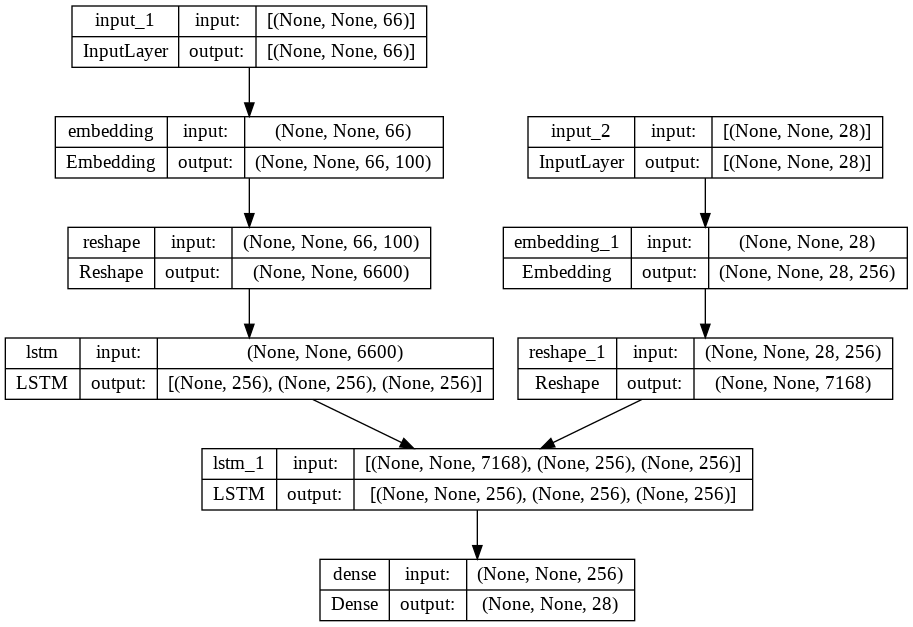

In [32]:
tf.keras.utils.plot_model(model, show_shapes=True, show_layer_names=True)

#Training

In [33]:
# Training
batch_size = 64  # Batch size for training.
epochs = 500  # Number of epochs to train for.
initial_learning_rate = 0.001

# Add callbacks:
# 'EarlyStopping' to stop training when the model is not enhancing anymore
# 'ModelCheckPoint' to always keep the model that has the best val_accuracy
model_save_filename = "model.h5"

model.compile(
    optimizer=tf.keras.optimizers.RMSprop(learning_rate=initial_learning_rate), 
    loss='categorical_crossentropy', 
    metrics=['accuracy'])

earlystopping_cb = EarlyStopping(
    monitor="val_accuracy",
    mode="max",
    verbose=1,
    patience=20, 
    restore_best_weights=True)

mdlcheckpoint_cb = ModelCheckpoint(  
    model_save_filename, 
    monitor="val_accuracy", 
    mode="max",
    verbose=1,
    save_best_only=True
)

decay = initial_learning_rate / epochs
def lr_time_based_decay(epoch, lr):
    return lr * 1 / (1 + decay * epoch)
lrscheduler_cb = tf.keras.callbacks.LearningRateScheduler(lr_time_based_decay)

history = model.fit([encoder_input_data, decoder_input_data], decoder_target_data,
          batch_size=batch_size, epochs=epochs,  validation_split=0.2, 
          callbacks=[earlystopping_cb, mdlcheckpoint_cb, lrscheduler_cb])


Epoch 1/500
 39/228 [====>.........................] - ETA: 9:36 - loss: 0.9316 - accuracy: 0.5717

KeyboardInterrupt: ignored

In [ ]:
history = model.fit([encoder_input_data, decoder_input_data], decoder_target_data,
          batch_size=batch_size, epochs=epochs,  validation_split=0.2, 
          callbacks=[earlystopping_cb, mdlcheckpoint_cb, lrscheduler_cb])

In [ ]:
# list all data in history
print(history.history.keys())  

In [ ]:
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

In [ ]:
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

#Inference

In [ ]:
# Restore the model and construct the encoder and decoder.
model = load_model(model_save_filename)
# model = load_model("model_v1.h5")

In [ ]:
# Predictions
encoder_inputs = model.input[0]  # input_1
encoder_outputs, state_h_enc, state_c_enc = model.layers[6].output  # lstm_1
encoder_states = [state_h_enc, state_c_enc]

encoder_model = Model(encoder_inputs, encoder_states)

decoder_inputs = model.input[1]  # input_2
decoder_inputs_em = decoder_embedding(decoder_inputs)

# since embedding layer will add one more dim, we need to flatten last 2 dims
decoder_reshape = Reshape((-1, decoder_inputs_em.shape[2] * decoder_inputs_em.shape[3]))
decoder_inputs_re = decoder_reshape(decoder_inputs_em)
print(decoder_inputs_re.shape)

decoder_state_input_h = Input(shape=(latent_dim,))
decoder_state_input_c = Input(shape=(latent_dim,))
decoder_states_inputs = [decoder_state_input_h, decoder_state_input_c]

decoder_lstm = model.layers[7] # lstm_2
decoder_outputs, state_h_dec, state_c_dec = decoder_lstm(
    decoder_inputs_re, initial_state=decoder_states_inputs
)

decoder_states = [state_h_dec, state_c_dec]

decoder_dense = model.layers[-1]
decoder_outputs = decoder_dense(decoder_outputs)

decoder_model = Model(
    [decoder_inputs] + decoder_states_inputs,
    [decoder_outputs] + decoder_states
)

In [ ]:
# Reverse-lookup token index to decode sequences back to
# something readable.
reverse_input_char_index = dict((i, char) for char, i in input_token_index.items())
reverse_target_char_index = dict((i, char) for char, i in target_token_index.items())

In [ ]:
tf.keras.utils.plot_model(encoder_model, to_file='model_plot_enc.png', show_shapes=True, show_layer_names=True)

In [ ]:
tf.keras.utils.plot_model(decoder_model, to_file='model_plot_dec.png', show_shapes=True, show_layer_names=True)

In [ ]:
def predict_target(input_string):
  # convert for encoding 
  input_data = np.zeros((1, max_encoder_seq_length, num_encoder_tokens), dtype='float32')
  for t, char in enumerate(input_string):
    input_data[0, t, input_token_index[char]] = 1.

  # Encode the input as state vectors.
  states_value = encoder_model(input_data)

   # Generate empty target sequence of length 1.
  target_seq = np.zeros((1, 1, num_decoder_tokens), dtype='float32')
  # Populate the first character of target sequence with the start character.
  target_seq[0, 0, target_token_index['^']] = 1.0

  stop_condition = False
  decoded_sentence = ""

  while True:
    output_tokens, d_h, d_c = decoder_model.predict([target_seq] + states_value)
    # Sample a token
    sampled_token_index = np.argmax(output_tokens[0, -1, :])
    sampled_char = reverse_target_char_index[sampled_token_index]

    # Exit condition: either hit max length
    # or find stop character.
    if sampled_char == "$" or len(decoded_sentence) > max_decoder_seq_length:
      break
      
    decoded_sentence += sampled_char

    # Update the target sequence (of length 1).
    target_seq = np.zeros((1, 1, num_decoder_tokens))
    target_seq[0, 0, sampled_token_index] = 1.0

    # Update states
    states_value = [d_h, d_c]
  return decoded_sentence

In [ ]:
test_input = 'राजशेखर'
predicted_string = predict_target(test_input)
predicted_string

In [ ]:
test_input = 'सूद'
predicted_string = predict_target(test_input)
predicted_string

In [ ]:
test_input = 'तन्मय'
predicted_string = predict_target(test_input)
predicted_string